In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
# Load datasets
df_customers = pd.read_csv('/Users/yongtengchai/Downloads/dataset/d_customers.csv')
df_flow_audience = pd.read_csv('/Users/yongtengchai/Downloads/dataset/flow_audience.csv')
df_business_unit = pd.read_csv('/Users/yongtengchai/Downloads/dataset/d_business_unit.csv')
df_sku = pd.read_csv('/Users/yongtengchai/Downloads/dataset/d_sku.csv')
df_transaction_detail = pd.read_csv('/Users/yongtengchai/Downloads/dataset/f_transaction_detail.csv')


In [57]:
# ['year_birthdate', 'gender_id', 'cnt_country_code']Focus on specific model codes at the beginning of the analysis
model_codes_of_interest = [7635140, 5015822, 7166996, 2486222]
sku_codes_of_interest = [
    7446648, 7448829, 7458761, 7449633, 7450422, 7461697, 7452235, 7452821, 
    7463948, 7458509, 7467777, 7463476, 7455608, 7458813, 7452661, 7457374, 
    7468857, 7467008, 7460340, 7448470, 7449064, 7442821, 7455088, 7457353, 7451543
]

# Creating a new column for hierarchical relationship between model and SKU
# This ensures that each SKU is recognized as a subcode of its mdl_num_model_r3
sku_model_mapping = {
    7635140: [7446648, 7448829, 7458761, 7449633, 7450422, 7461697, 7452235],
    5015822: [7452821, 7463948, 7458509, 7467777, 7463476],
    7166996: [7455608, 7458813, 7452661, 7457374, 7468857, 7467008],
    2486222: [7460340, 7448470, 7449064, 7442821, 7455088, 7457353, 7451543]
}


# Filtering dataset to include only the specific SKUs under their respective model codes
df_sku_filtered = df_sku[(df_sku['mdl_num_model_r3'].isin(model_codes_of_interest)) & (df_sku['sku_idr_sku'].isin(sku_codes_of_interest))]
df_transaction_detail_filtered = pd.merge(df_transaction_detail, df_sku_filtered, on='sku_idr_sku', how='inner')

# Adding a new column to indicate the hierarchical mapping of SKU to Model
# This ensures that each SKU is associated with its model code explicitly in the merged dataset
df_transaction_detail_filtered['mdl_num_model_r3'] = df_transaction_detail_filtered['sku_idr_sku'].map(
    {sku: model for model, skus in sku_model_mapping.items() for sku in skus}
)

# Merge datasets to create a comprehensive dataset for analysis
# Merging transaction details with customer information
merged_df = pd.merge(df_transaction_detail_filtered, df_customers, left_on='ctm_customer_id', right_on='loyalty_card_num', how='left')


In [58]:
# Analysis 1: Determine if the target of rejuvenating the customer base was achieved
# Filtering customers by year of birth to identify Generation Z (born 1997-2012)
gen_z_customers = merged_df[(merged_df['year_birthdate'] >= 1997) & (merged_df['year_birthdate'] <= 2012)]

# Calculate the number of Gen Z customers
num_gen_z_customers = gen_z_customers['ctm_customer_id'].nunique()

# Calculate the total number of customers who purchased during the campaign
total_customers = merged_df['ctm_customer_id'].nunique()

# Calculate the percentage of Gen Z customers
percentage_gen_z = (num_gen_z_customers / total_customers) * 100

# Calculate the number of new customers (assuming loyalty_card_creation_date as an indicator of new customers)
new_customers = merged_df[pd.to_datetime(merged_df['loyalty_card_creation_date']).dt.year == 2020]
num_new_customers = new_customers['ctm_customer_id'].nunique()

print(f"Number of Generation Z customers: {num_gen_z_customers}")
print(f"Total number of customers: {total_customers}")
print(f"Percentage of Generation Z customers: {percentage_gen_z:.2f}%")
print(f"Number of new customers acquired during the campaign: {num_new_customers}")

Number of Generation Z customers: 189
Total number of customers: 3913
Percentage of Generation Z customers: 4.83%
Number of new customers acquired during the campaign: 1716


In [28]:
# Analysis 2: Determine if the campaign was profitable
# Calculate total turnover and the profit margin
merged_df['profit'] = merged_df['f_to_tax_in'] * 0.20  # Assuming a 20% profit margin
total_profit = merged_df['profit'].sum()

# Calculate the total revenue
total_revenue = merged_df['f_to_tax_in'].sum()

print(f"Total number of customers: {total_customers}")

# Calculate average spend per customer
average_spend_per_customer = total_revenue / total_customers

print(f"Total Profit from the Campaign: €{total_profit:.2f}")
print(f"Total Revenue from the Campaign: €{total_revenue:.2f}")
print(f"Average Spend per Customer: €{average_spend_per_customer:.2f}")

Total number of customers: 3913
Total Profit from the Campaign: €44867.20
Total Revenue from the Campaign: €224336.00
Average Spend per Customer: €57.33


/var/folders/2t/k877r5k53857q27lmls39hrw0000gn/T/ipykernel_35822/961884988.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=customer_segments, x='age_group', y='loyalty_card_num', ci=None)


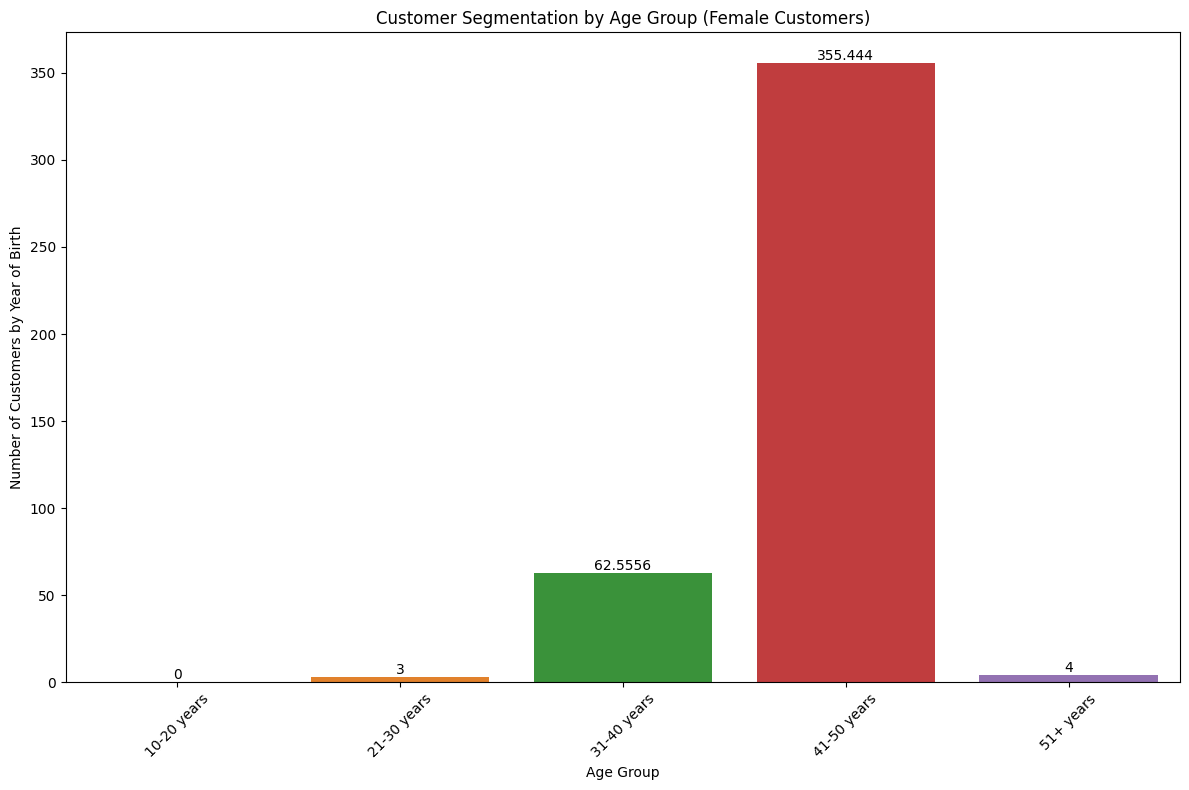

In [63]:
# Analysis 3: Group customers by age, and gender for customer segment analysis
df_customers['age_group'] = pd.cut(df_customers['year_birthdate'], bins=[1920, 1940, 1960, 1980, 2000, 2022], labels=['10-20 years', '21-30 years', '31-40 years', '41-50 years', '51+ years'])
filtered_customers = merged_df[(merged_df['mdl_num_model_r3'].isin(model_codes_of_interest)) & (merged_df['gender_id'] == 2)]
customer_segments = filtered_customers.groupby(['age_group', 'gender_id', 'cnt_country_code_creator']).agg({'loyalty_card_num': 'count'}).reset_index()


# Plotting customer segments by age, gender, and location
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=customer_segments, x='age_group', y='loyalty_card_num', ci=None)

# Adding labels to each bar
for container in ax.containers:
    ax.bar_label(container)

# Customizing plot appearance
plt.xlabel('Age Group')
plt.ylabel('Number of Customers by Year of Birth')
plt.title('Customer Segmentation by Age Group (Female Customers)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Top 10 products by quantity sold:
   sku_idr_sku  f_qty_item  f_to_tax_in  mdl_num_model_r3
0      7457374         515      17990.0         7166996.0
1      7463476         514      10280.0         5015822.0
2      7449633         506      10040.0         7635140.0
3      7458813         474      16555.0         7166996.0
4      7467777         427       8400.0         5015822.0
5      7458761         407       8060.0         7635140.0
6      7458509         363       7200.0         5015822.0
7      7460340         352      15795.0         2486222.0
8      7451543         349      15570.0         2486222.0
9      7446648         341       6720.0         7635140.0


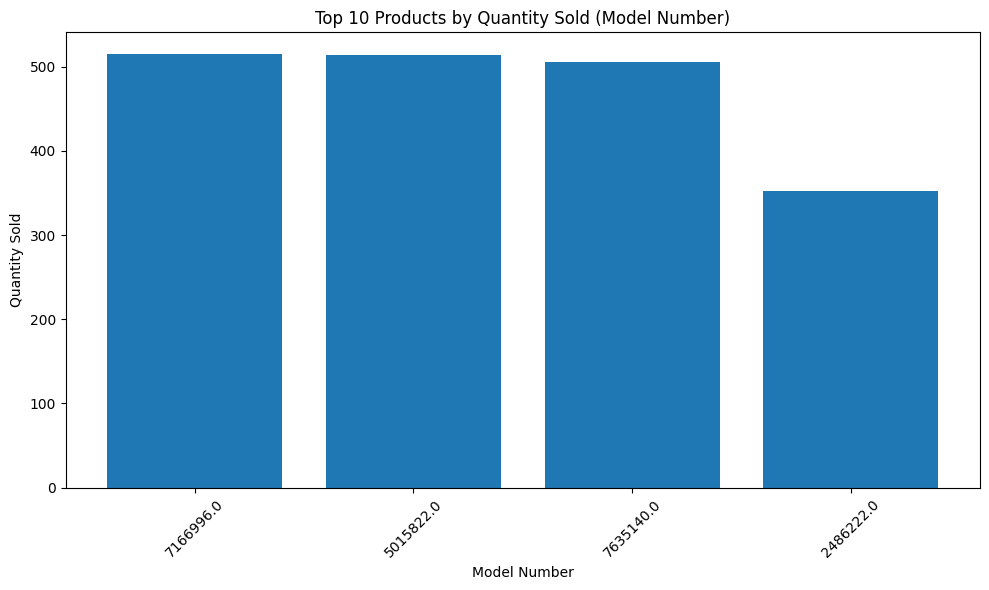

In [86]:
# Analysis 4: Product performance analysis
# Group by SKU to find out which products were the most popular
product_performance = merged_df.groupby('sku_idr_sku').agg({
    'f_qty_item': 'sum',
    'f_to_tax_in': 'sum'
}).reset_index()

# Sorting products by quantity sold
top_products = product_performance.sort_values(by='f_qty_item', ascending=False)

# Include model number for better analysis
top_products = pd.merge(top_products, df_sku[['sku_idr_sku', 'mdl_num_model_r3']], on='sku_idr_sku', how='left')

print("Top 10 products by quantity sold:")
print(top_products.head(10))


# Plot 2: f_qty_item by mdl_num_model_r3
plt.figure(figsize=(10, 6))
bars = plt.bar(top_products['mdl_num_model_r3'].head(10).astype(str), top_products['f_qty_item'].head(10))


# Customizing plot appearance
plt.xlabel('Model Number')
plt.ylabel('Quantity Sold')
plt.title('Top 10 Products by Quantity Sold (Model Number)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



/var/folders/2t/k877r5k53857q27lmls39hrw0000gn/T/ipykernel_35822/1525555172.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=model_quantity_analysis, x='mdl_num_model_r3', y='f_qty_item', ci=None)


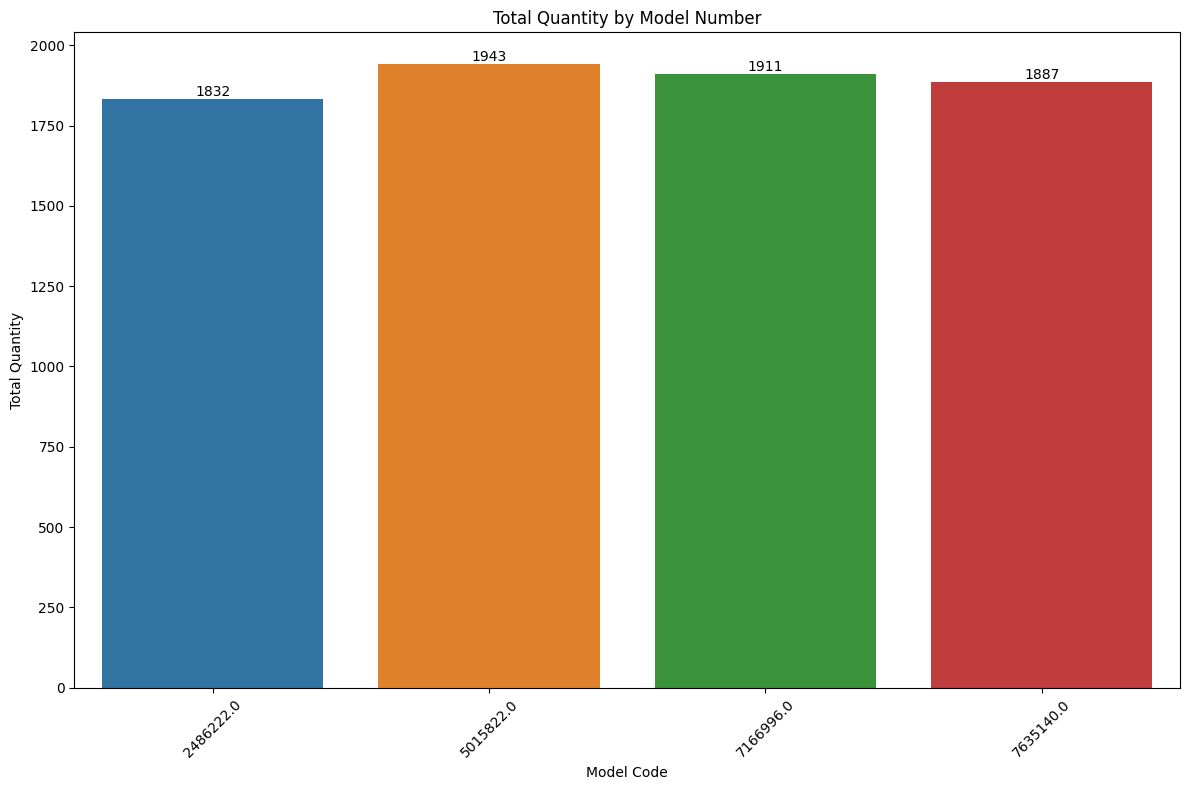

In [80]:
# Analysis 5: Transaction Types and Status Visualization
# Grouping transaction details to visualize transaction types, transaction status, and type details
transaction_analysis = df_transaction_detail_filtered.groupby(['the_to_type', 'the_transaction_status', 'tdt_type_detail']).agg({
    'f_to_tax_in': 'sum',
    'f_qty_item': 'sum'
}).reset_index()

# Plotting Total Quantity by mdl_num_model_r3 (specific model codes)
plt.figure(figsize=(12, 8))
model_quantity_analysis = df_transaction_detail_filtered.groupby('mdl_num_model_r3').agg({'f_qty_item': 'sum'}).reset_index()
ax = sns.barplot(data=model_quantity_analysis, x='mdl_num_model_r3', y='f_qty_item', ci=None)

# Adding labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')  # Adjust format as needed

# Customizing plot appearance
plt.xlabel('Model Code')
plt.ylabel('Total Quantity')
plt.title('Total Quantity by Model Number')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/2t/k877r5k53857q27lmls39hrw0000gn/T/ipykernel_35822/2974473623.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=transaction_type_analysis, x='mdl_num_model_r3', y='f_qty_item', hue='the_to_type', ci=None)


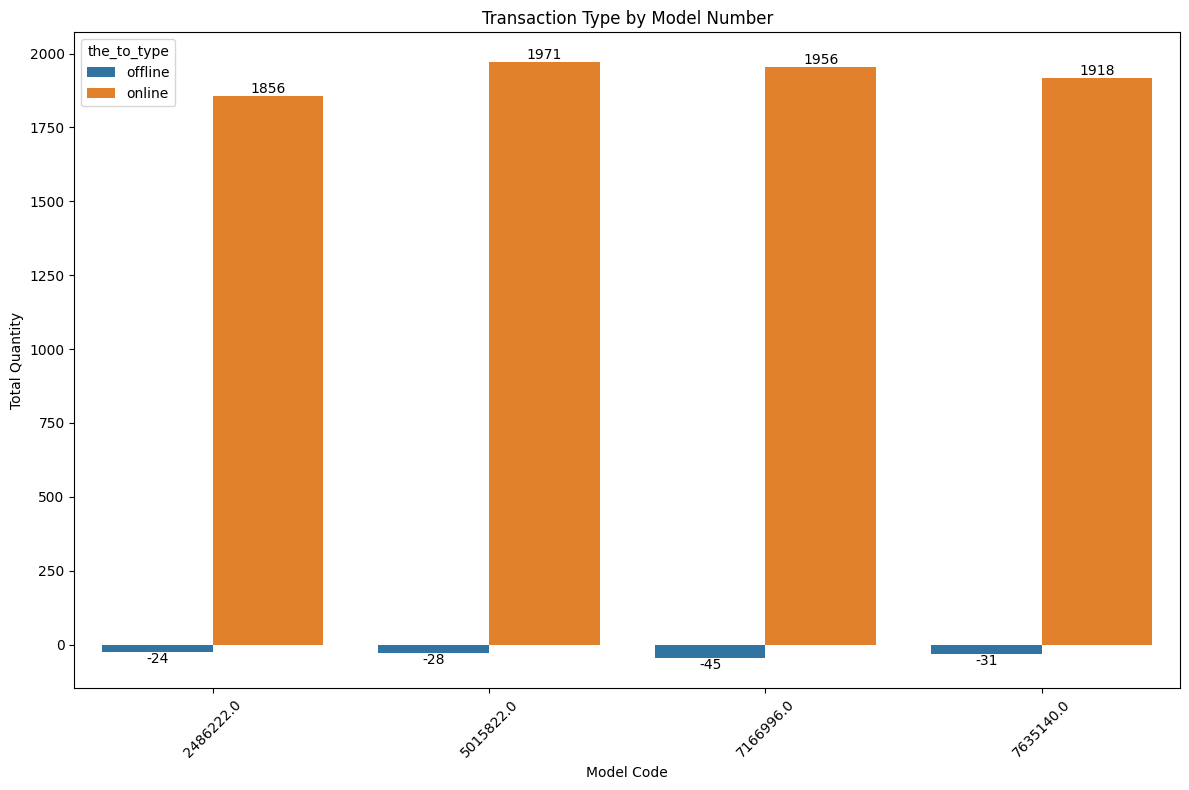

In [81]:
# Plotting Transaction Type by mdl_num_model_r3 (specific model codes)
plt.figure(figsize=(12, 8))
transaction_type_analysis = df_transaction_detail_filtered.groupby(['mdl_num_model_r3', 'the_to_type']).agg({'f_qty_item': 'sum'}).reset_index()
ax = sns.barplot(data=transaction_type_analysis, x='mdl_num_model_r3', y='f_qty_item', hue='the_to_type', ci=None)

# Adding labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')  # Adjust format as needed

# Customizing plot appearance
plt.xlabel('Model Code')
plt.ylabel('Total Quantity')
plt.title('Transaction Type by Model Number')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/2t/k877r5k53857q27lmls39hrw0000gn/T/ipykernel_35822/1031170859.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(data=transaction_status_analysis_sku, x='mdl_num_model_r3', y='count', hue='the_transaction_status', ci=None)


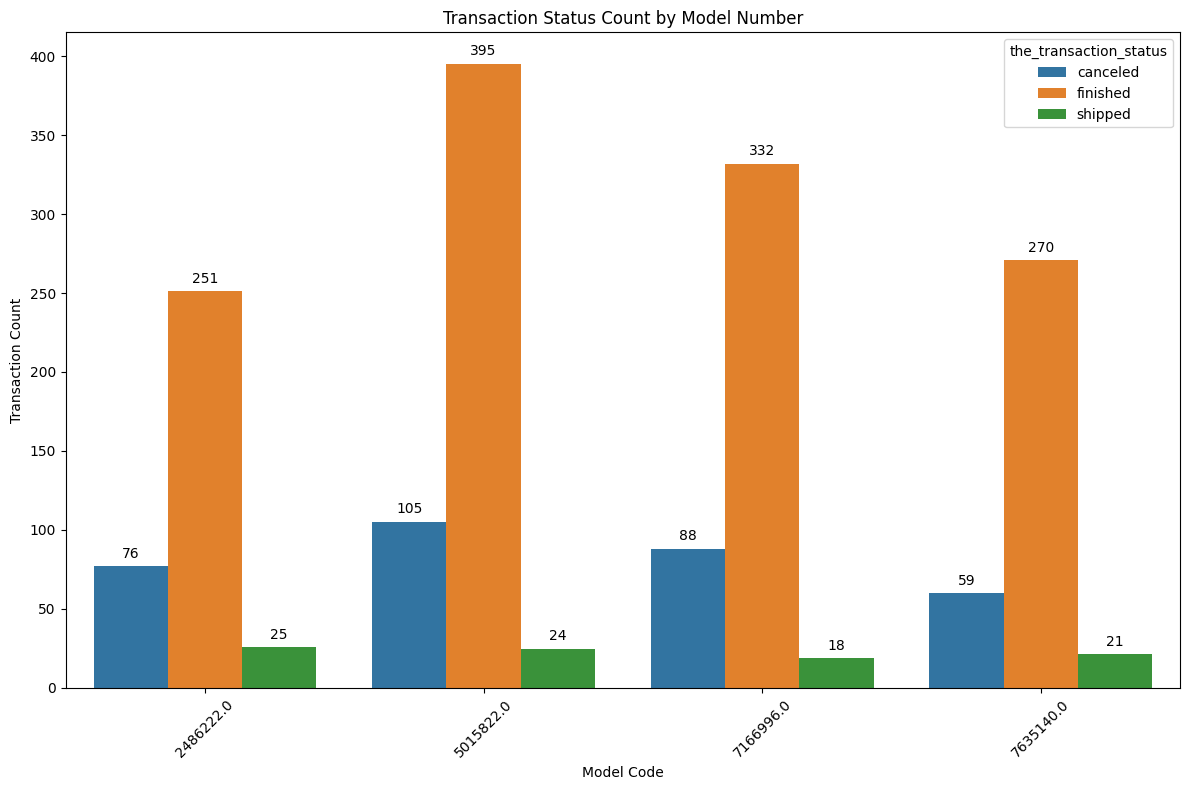

In [84]:
# Analysis 6: Transaction Status Visualization for SKU Codes Only
# Plotting Transaction Status by SKU codes under each main model code
plt.figure(figsize=(12, 8))
transaction_status_analysis_sku = df_transaction_detail_filtered[df_transaction_detail_filtered['mdl_num_model_r3'].isin(model_codes_of_interest)].groupby(['mdl_num_model_r3', 'sku_idr_sku', 'the_transaction_status']).size().reset_index(name='count')
barplot = sns.barplot(data=transaction_status_analysis_sku, x='mdl_num_model_r3', y='count', hue='the_transaction_status', ci=None)
plt.xlabel('Model Code')
plt.ylabel('Transaction Count')
plt.title('Transaction Status Count by Model Number')
plt.xticks(rotation=45)

# Adding labels to each bar
for p in barplot.patches:
    barplot.annotate(format(int(p.get_height()), 'd'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.tight_layout()
plt.show()

/var/folders/2t/k877r5k53857q27lmls39hrw0000gn/T/ipykernel_35822/3175410728.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=transaction_analysis, x='tdt_type_detail', y='f_qty_item', ci=None)


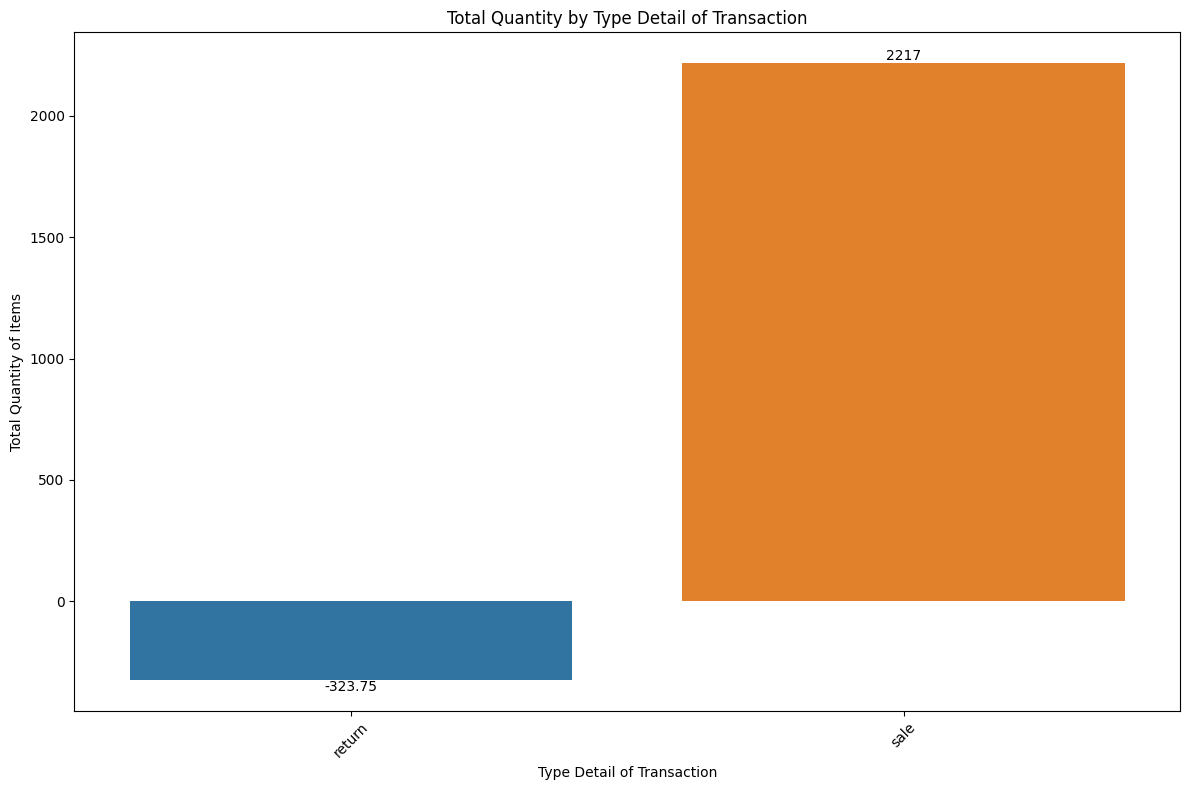

In [65]:

# Plotting Type Detail of Transactions
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=transaction_analysis, x='tdt_type_detail', y='f_qty_item', ci=None)

# Adding labels to each bar
for container in ax.containers:
    ax.bar_label(container)

# Customizing plot appearance
plt.xlabel('Type Detail of Transaction')
plt.ylabel('Total Quantity of Items')
plt.title('Total Quantity by Type Detail of Transaction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/2t/k877r5k53857q27lmls39hrw0000gn/T/ipykernel_35822/314343992.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=purchasing_patterns, x='age_group', y='f_to_tax_in', ci=None)


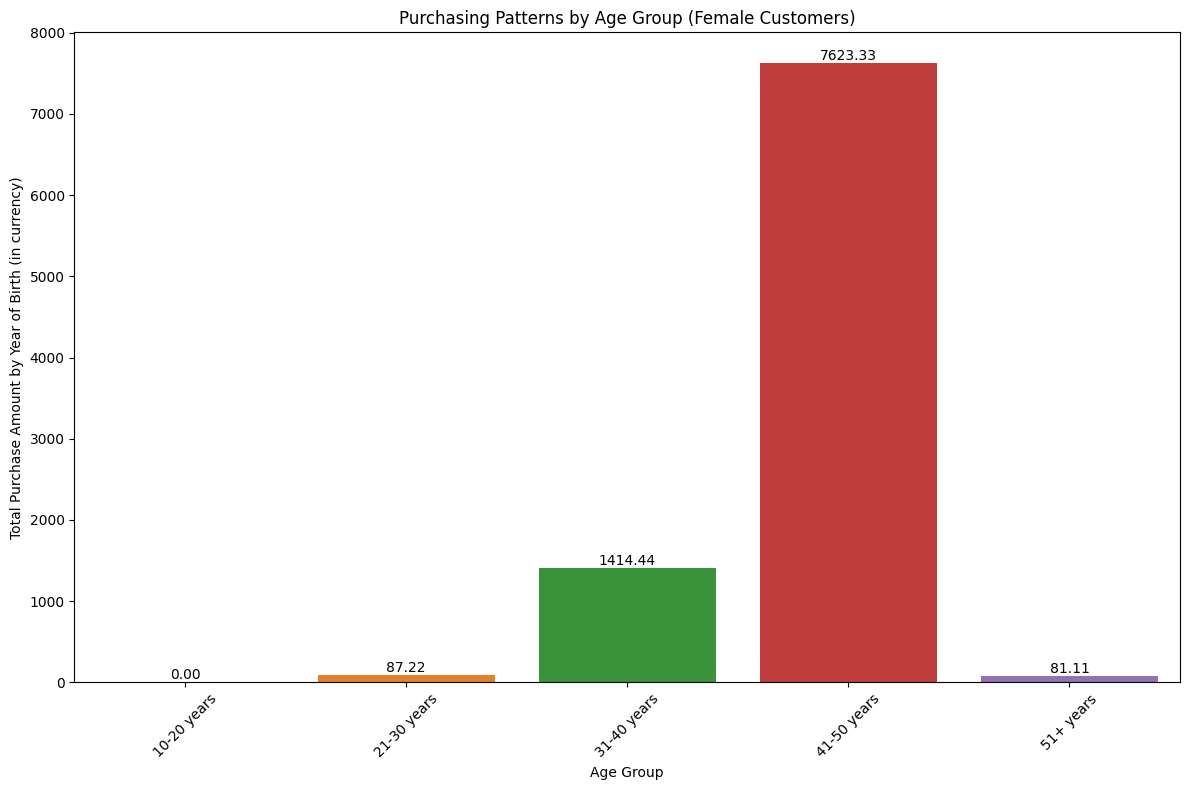

In [66]:
# Plotting purchasing patterns by customer segments
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=purchasing_patterns, x='age_group', y='f_to_tax_in', ci=None)

# Adding labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')  # Adjust the format as needed, e.g., currency format

# Customizing plot appearance
plt.xlabel('Age Group')
plt.ylabel('Total Purchase Amount by Year of Birth (in currency)')
plt.title('Purchasing Patterns by Age Group (Female Customers)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/2t/k877r5k53857q27lmls39hrw0000gn/T/ipykernel_35822/2657753023.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'but_name_business_unit_x', 'cnt_country_code_x', 'but_postcode_x', 'cnt_idr_country_x', 'but_num_typ_but_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = pd.merge(merged_df, df_business_unit, left_on='but_idr_business_unit', right_on='but_idr_business_unit', how='left')
/var/folders/2t/k877r5k53857q27lmls39hrw0000gn/T/ipykernel_35822/2657753023.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=customer_loyalty_analysis, x='age_group', y='loyalty_card_num', ci=None)


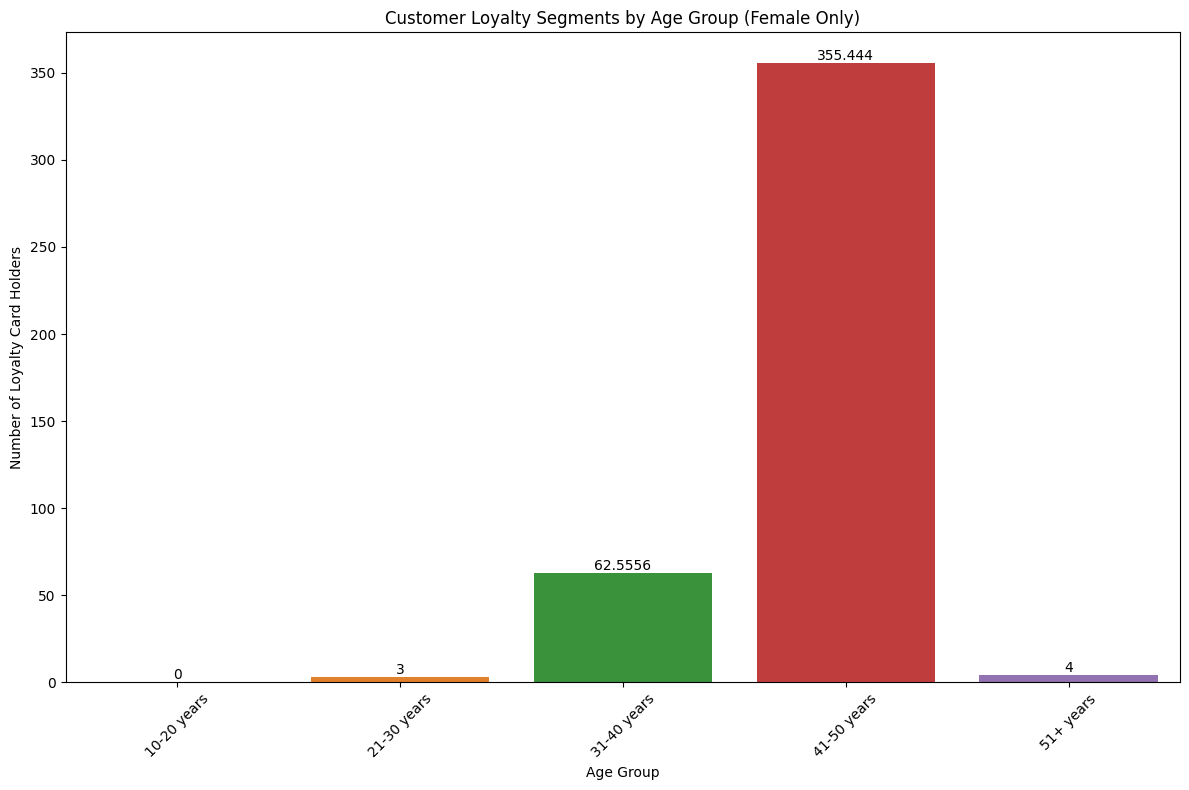

In [85]:
# Merging with business unit details to get shop information
merged_df = pd.merge(merged_df, df_business_unit, left_on='but_idr_business_unit', right_on='but_idr_business_unit', how='left')

# Filtering for female customers only
merged_df = merged_df[merged_df['gender_id'] == 2]

# Analysis 7: Customer Loyalty and Segment Analysis
# Using the filtered dataset for female customers to group by age, gender, and location for loyalty analysis
customer_loyalty_analysis = merged_df.groupby(['age_group', 'cnt_country_code_creator']).agg({
    'loyalty_card_num': 'count'
}).reset_index()


# Plotting Customer Loyalty Segments by Age and Gender
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=customer_loyalty_analysis, x='age_group', y='loyalty_card_num', ci=None)

# Adding labels to each bar
for container in ax.containers:
    ax.bar_label(container)

# Customizing plot appearance
plt.xlabel('Age Group')
plt.ylabel('Number of Loyalty Card Holders')
plt.title('Customer Loyalty Segments by Age Group (Female Only)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
# Analysis 8: Product model analysis using model codes (based on specific model codes only)
# Filtering to include only the specific model codes provided: 7635140, 5015822, 7166996, 2486222
filtered_models = merged_df[merged_df['mdl_num_model_r3'].isin(model_codes_of_interest)]

# Grouping by model code to analyze the performance of these specific product models
model_performance = filtered_models.groupby('mdl_num_model_r3').agg({
    'f_qty_item': 'sum',
    'f_to_tax_in': 'sum'
}).reset_index()

# Sorting models by quantity sold
top_models = model_performance.sort_values(by='f_qty_item', ascending=False)

print("Top specific product models by quantity sold:")
print(top_models.head())

Top specific product models by quantity sold:
   mdl_num_model_r3  f_qty_item  f_to_tax_in
1         5015822.0        1726      34300.0
2         7166996.0        1690      58920.0
3         7635140.0        1646      32620.0
0         2486222.0        1590      70920.0


/var/folders/2t/k877r5k53857q27lmls39hrw0000gn/T/ipykernel_35822/325217016.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=instock_summary, x='product_id_model', y='tot_visitors', hue='product_instock', ci=None)


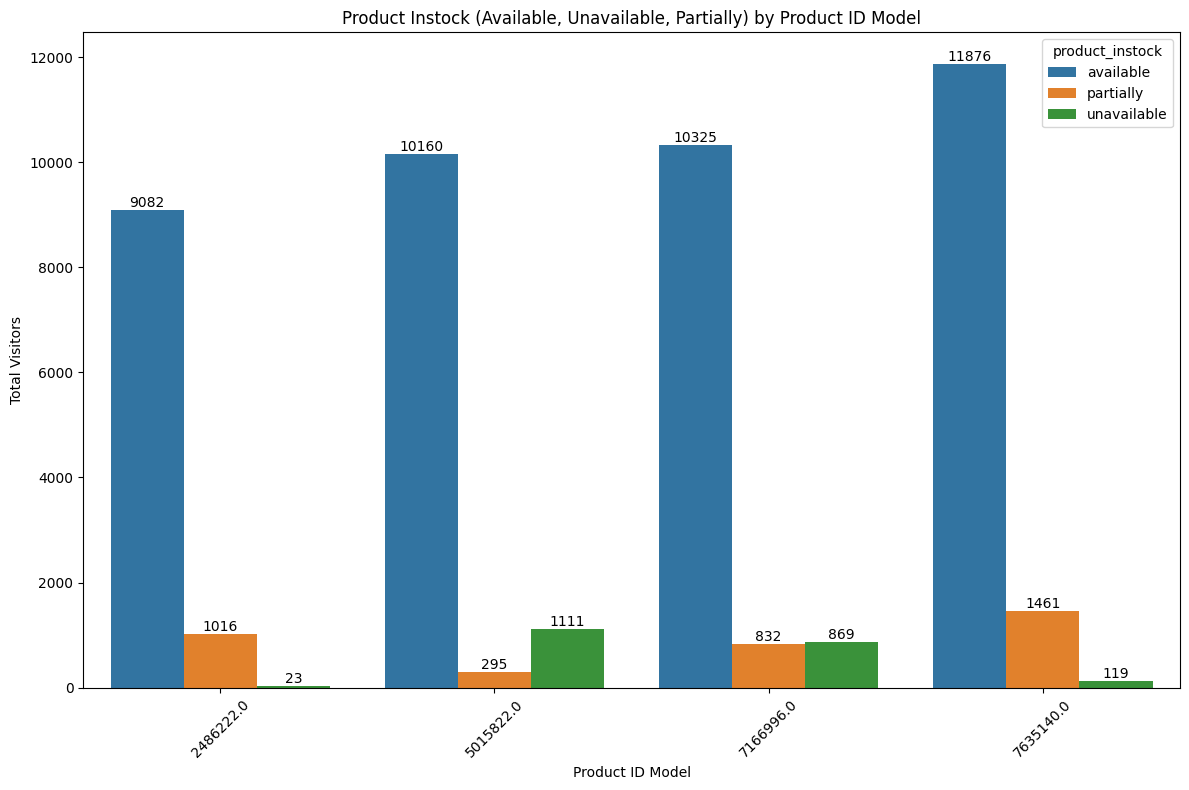

In [71]:
# Analysis 9: Product Instock by Product ID Model (Available, Unavailable, Partially)
# Filtering flow_audience data for specific model codes
instock_device_analysis = df_flow_audience[df_flow_audience['product_id_model'].isin(model_codes_of_interest)]

# Creating a pivot table to summarize product instock status (available, unavailable, partially) by product_id_model
instock_summary = instock_device_analysis.groupby(['product_id_model', 'product_instock']).agg({
    'tot_visitors': 'sum'
}).reset_index()

# Plotting product instock (available, unavailable, partially) by product_id_model
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=instock_summary, x='product_id_model', y='tot_visitors', hue='product_instock', ci=None)

# Adding labels to each bar
for container in ax.containers:
    ax.bar_label(container)

# Customizing plot appearance
plt.xlabel('Product ID Model')
plt.ylabel('Total Visitors')
plt.title('Product Instock (Available, Unavailable, Partially) by Product ID Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/2t/k877r5k53857q27lmls39hrw0000gn/T/ipykernel_35822/1303352282.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=engagement_metrics, x='device_type', y='tot_visitors', ci=None)


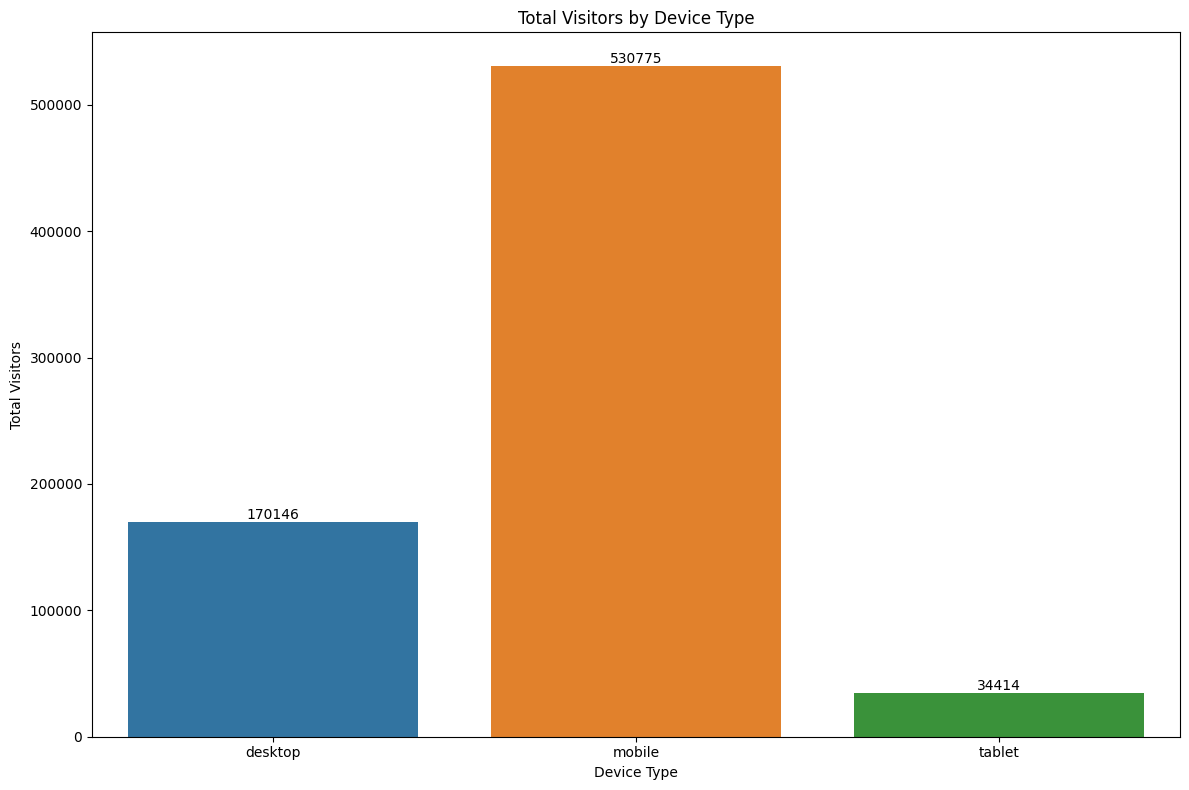

In [72]:
# Analysis 10: Engagement Metrics by Device Type
# Checking if necessary columns exist for analysis
engagement_metrics_available = all(col in df_flow_audience.columns for col in ['tot_visitors', 'device_type'])
if engagement_metrics_available:
    # Plotting Total Visitors by Device Type
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=engagement_metrics, x='device_type', y='tot_visitors', ci=None)

    # Adding labels to each bar
    for container in ax.containers:
        ax.bar_label(container)

    # Customizing plot appearance
    plt.xlabel('Device Type')
    plt.ylabel('Total Visitors')
    plt.title('Total Visitors by Device Type')
    plt.tight_layout()
    plt.show()

/var/folders/2t/k877r5k53857q27lmls39hrw0000gn/T/ipykernel_35822/950430124.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=sales_performance, x='but_num_typ_but', y='f_to_tax_in', ci=None)


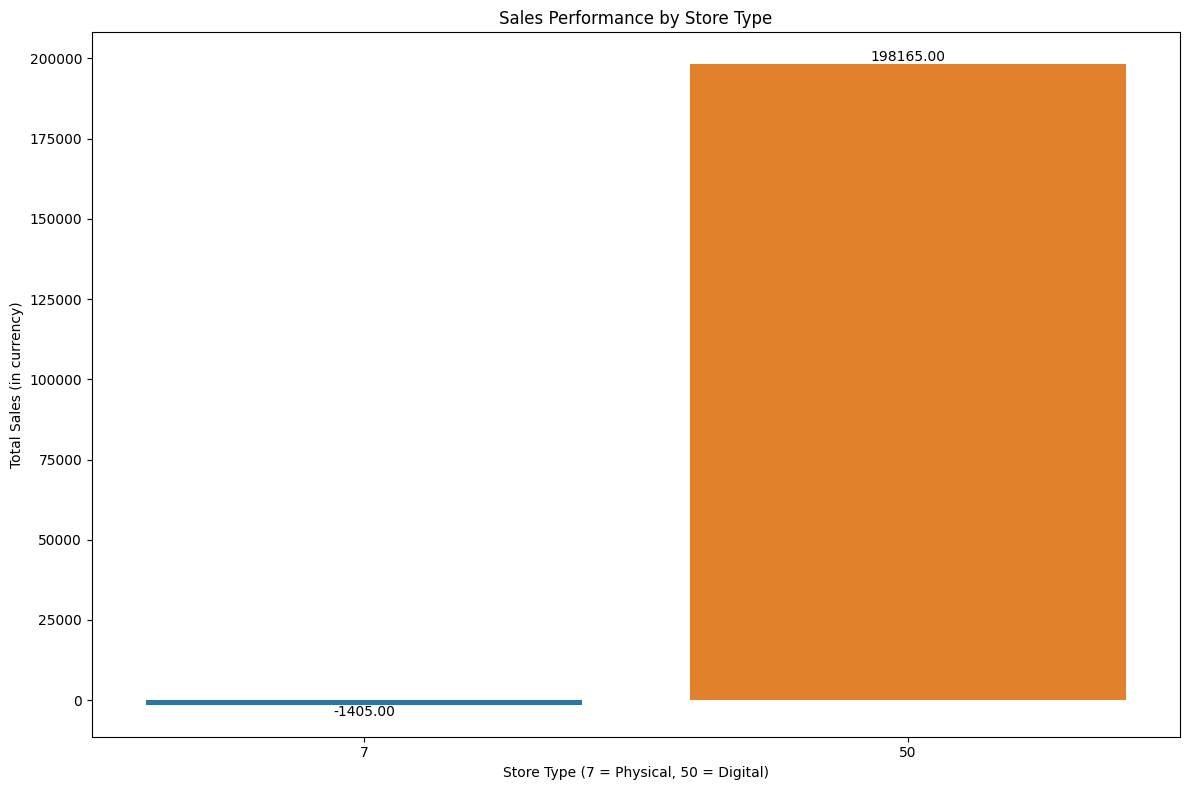

In [73]:
# Analysis 11: Sales Performance and Revenue by Store Type
# Using the merged data for sales performance analysis

# Sales performance analysis using merged_df that already contains customer and business unit details
sales_data = merged_df





# Plotting sales performance by store type
if 'sales_performance' in locals() and not sales_performance.empty:
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=sales_performance, x='but_num_typ_but', y='f_to_tax_in', ci=None)
    
    # Adding labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')  # Adjust format as needed

    # Customizing plot appearance
    plt.xlabel('Store Type (7 = Physical, 50 = Digital)')
    plt.ylabel('Total Sales (in currency)')
    plt.title('Sales Performance by Store Type')
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot Sales Performance by Store Type.")

/var/folders/2t/k877r5k53857q27lmls39hrw0000gn/T/ipykernel_35822/1158106761.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=sales_performance_analysis, x='mdl_num_model_r3', y='f_to_tax_in', hue='but_num_typ_but', ci=None)


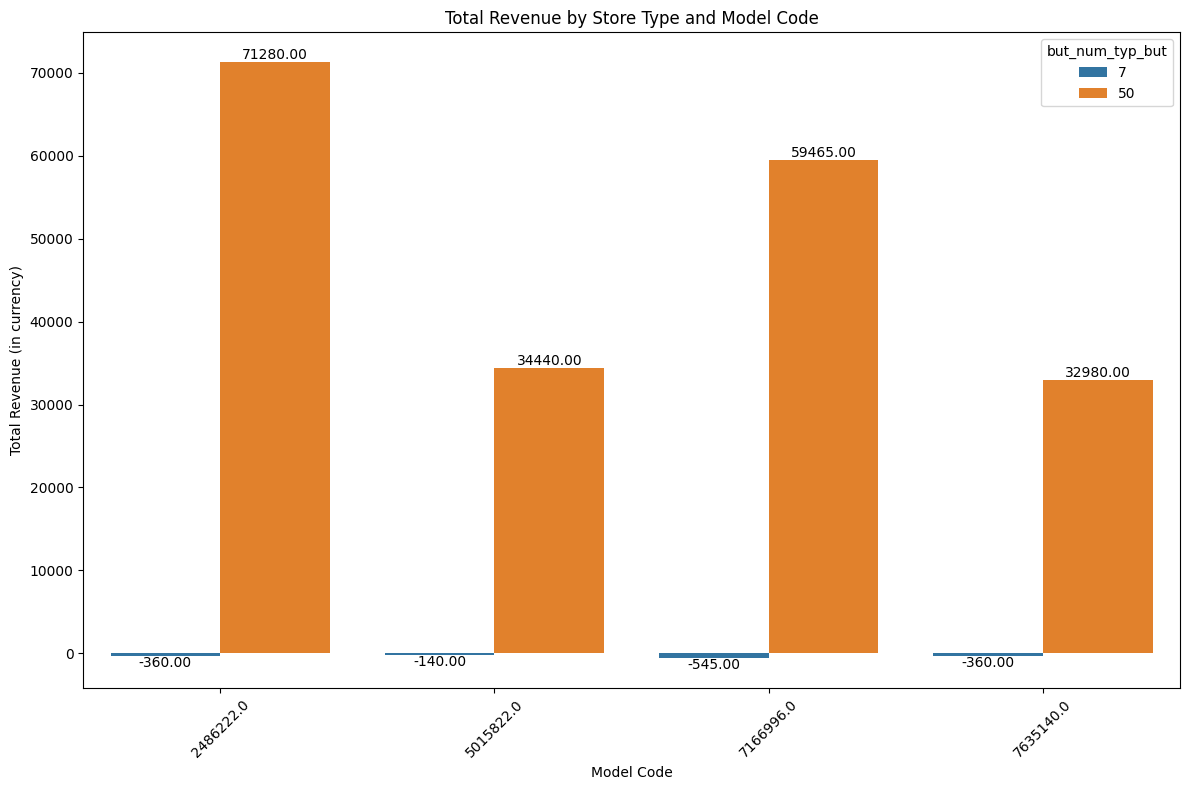

In [75]:
# Plotting Sales Performance by Store Type for Specific Model Codes
plt.figure(figsize=(12, 8))
sales_performance_analysis = merged_df[merged_df['mdl_num_model_r3'].isin(model_codes_of_interest)].groupby(['but_num_typ_but', 'mdl_num_model_r3']).agg({'f_to_tax_in': 'sum'}).reset_index()
ax = sns.barplot(data=sales_performance_analysis, x='mdl_num_model_r3', y='f_to_tax_in', hue='but_num_typ_but', ci=None)

# Adding labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')  # Adjust format as needed

# Customizing plot appearance
plt.xlabel('Model Code')
plt.ylabel('Total Revenue (in currency)')
plt.title('Total Revenue by Store Type and Model Code')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()